<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
def load_data(file_dir):
    data = pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    return data
def clean_data(data):
  data.replace('?',np.NaN,inplace=True)
  data = data.fillna(method='bfill')
  data = data.astype('float32')
  return data

def scaling_data(data):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(data)
  return scaled,scaler

def series_to_supervised(df_as_np,n_lags,n_out=1):
  X,y = [],[]
  for i in range(len(df_as_np)-n_lags):
    row = [ a for a in df_as_np[i:i+n_lags]]
    X.append(row)
    label = df_as_np[i+n_lags:i+n_lags+n_out,0]
    y.append(label)
  return np.array(X), np.array(y)

In [32]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [57]:
cols=['Global_active_power', 'Global_reactive_power', 'Global_intensity']
dataset = dataset[cols]
dataset = clean_data(dataset)
dataset = dataset.resample('H').mean()
data_as_np,scaler = scaling_data(dataset)
n_lags=12
n_out=1
input,target = series_to_supervised(data_as_np,n_lags,n_out)
input , target = input[500:],target[500:]
train_input = input[:23000]
test_input = input[26000:]
validation_input = input[23000:26000]
train_target = target[:23000]
test_target = target[26000:]
validation_target = target[23000:26000]
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 12, 3), (8077, 12, 3), (23000, 1), (8077, 1))

In [ ]:
#date_index=new_data.index.to_series()
#new_data['year']=date_index.dt.year
#new_data['month']=date_index.dt.month
#new_data['day_of_week']=date_index.dt.dayofweek
#new_data['hour']=date_index.dt.hour
#new_data = new_data.reset_index(drop=True)

#new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
#new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)

#new_data['Global_active_power'] = 1000*new_data['Global_active_power']

#new_data.drop(labels=['hour'],axis=1,inplace=True)
#new_data.drop(labels=['Global_active_power'],axis=1,inplace=True)

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float32
 1   Global_reactive_power  34589 non-null  float32
 2   Global_intensity       34589 non-null  float32
dtypes: float32(3)
memory usage: 675.6 KB


# Models...

**model1..LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [42]:

model1 = Sequential()
# input layer...
model1.add(LSTM(100,activation='relu',input_shape =(n_lags, len(cols))))
model1.add(Dropout(0.2))
model1.add(Dense(8, 'relu'))
#output layer...
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               41600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 808       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 42,417
Trainable params: 42,417
Non-trainable params: 0
_________________________________________________________________


In [60]:
#cp1 = ModelCheckpoint('model1/', save_best_only=True)

model1.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#model_summary = model1.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=20, batch_size=70, callbacks=[cp1])
model_summary = model1.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=20, batch_size=70)

Epoch 1/10
329/329 [==============================] - 7s 16ms/step - loss: 0.0089 - accuracy: 4.3478e-05 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 2/10
329/329 [==============================] - 5s 15ms/step - loss: 0.0089 - accuracy: 4.3478e-05 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 3/10
329/329 [==============================] - 6s 17ms/step - loss: 0.0089 - accuracy: 4.3478e-05 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 4/10
329/329 [==============================] - 5s 15ms/step - loss: 0.0089 - accuracy: 4.3478e-05 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 5/10
329/329 [==============================] - 7s 22ms/step - loss: 0.0088 - accuracy: 4.3478e-05 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 6/10
329/329 [==============================] - 8s 25ms/step - loss: 0.0089 - accuracy: 4.3478e-05 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 7/10
329/329 [==============================] - 5s 16ms/step - loss: 0.0089 - accuracy: 

In [ ]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(model_summary.history['loss'])
plt.plot(model_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [75]:
x=pd.DataFrame({'a':[10,20,30],'b':[5,25,35]})
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(x)
scaled

array([[0.        , 0.        ],
       [0.5       , 0.66666667],
       [1.        , 1.        ]])

In [79]:
scaler.inverse_transform(np.array([[10,20,30],[2,5,3]]))

ValueError: ignored

In [62]:
from keras.models import load_model
model1 = load_model('model1/')

In [63]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [ ]:
test_predictions = model1.predict(test_input).flatten()
shape = (test_predictions.shape[0],1)
test_predicted = scaler.inverse_transform(np.concatenate((test_predictions.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_target = scaler.inverse_transform(np.concatenate((test_target.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_results = pd.DataFrame(data={'test_predicted':test_predicted, 'test_target':test_target})
test_results

In [108]:
shape = (test_predictions.shape[0],1)
np.concatenate((test_predictions.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1)[:,0]

array([0.23031819, 0.30468708, 0.30162039, ..., 0.23507243, 0.23846388,
       0.1541187 ])

In [71]:
np.mean(abs(test_results.test_predicted-test_results.test_target)/test_results.test_target)

0.6403005719184875

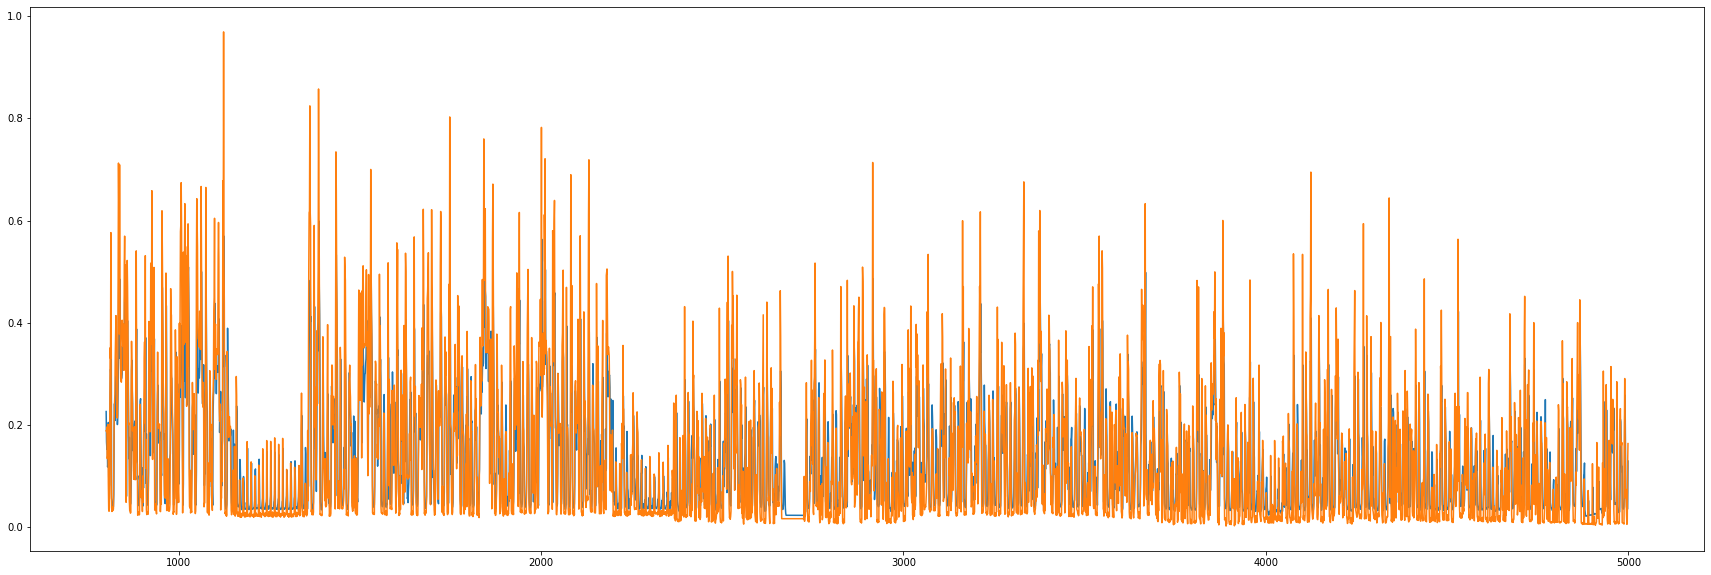

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(train_results['train_predicted'][800:5000])
plt.plot(train_results['train_target'][800:5000])

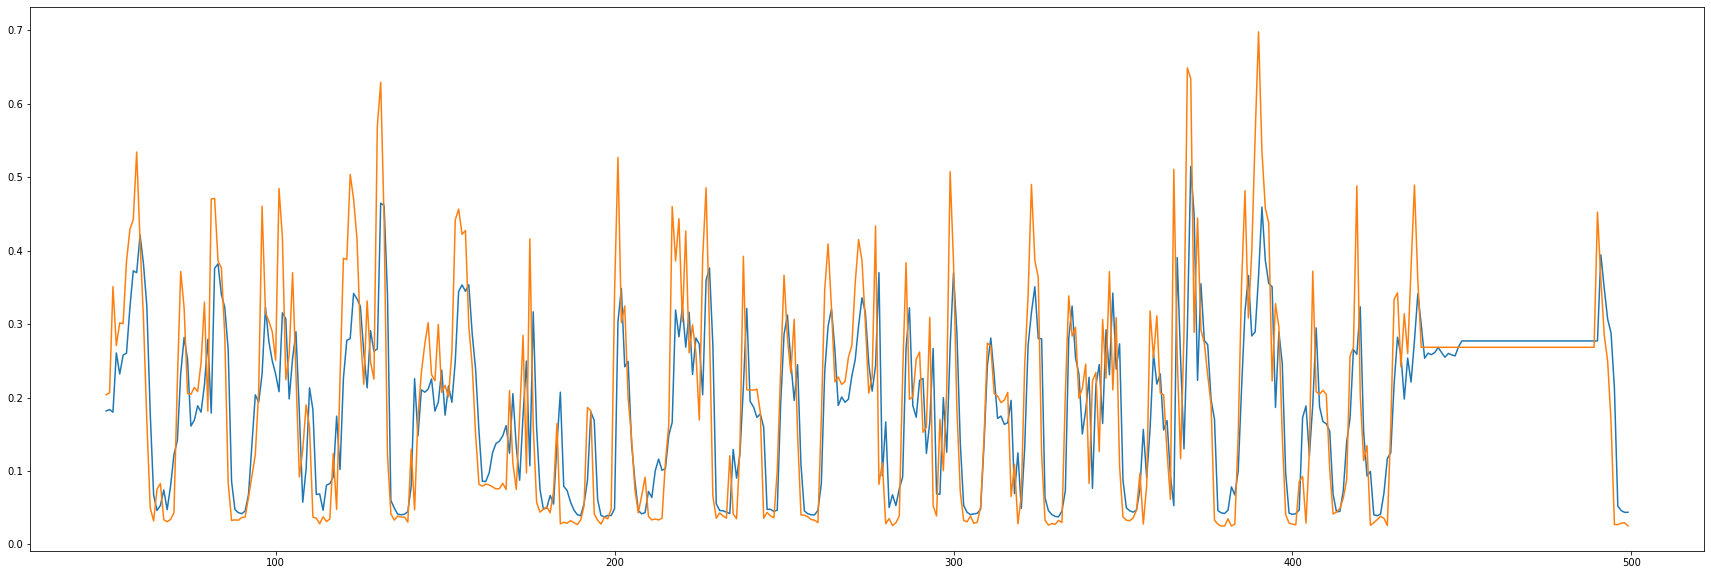

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(test_results['test_predicted'][50:500])
plt.plot(test_results['test_target'][50:500])

**MODEL2..Conv1D**

In [ ]:
model2 = Sequential()
model2.add(InputLayer((100, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp2])

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [ ]:
test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_absolute_percentage_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_absolute_percentage_error(train_results.train_predicted,train_results.train_target)

**Model3...GRU**

In [ ]:
model3 = Sequential()
model3.add(InputLayer((100, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)